# Contextual Bandits with Amazon SageMaker RL

We demonstrate how you can manage your own contextual multi-armed bandit workflow on SageMaker using the built-in [Vowpal Wabbit (VW)](https://github.com/VowpalWabbit/vowpal_wabbit) container to train and deploy contextual bandit models. We show how to train these models that interact with a live environment (using a simulated client application) and continuously update the model with efficient exploration.

### Why Contextual Bandits?

Wherever we look to personalize content for a user (content layout, ads, search, product recommendations, etc.), contextual bandits come in handy. Traditional personalization methods collect a training dataset, build a model and deploy it for generating recommendations. However, the training algorithm does not inform us on how to collect this dataset, especially in a production system where generating poor recommendations lead to loss of revenue. Contextual bandit algorithms help us collect this data in a strategic manner by trading off between exploiting known information and exploring recommendations which may yield higher benefits. The collected data is used to update the personalization model in an online manner. Therefore, contextual bandits help us train a personalization model while minimizing the impact of poor recommendations.

### What does this notebook contain?

To implement the exploration-exploitation strategy, we need an iterative training and deployment system that: (1) recommends an action using the contextual bandit model based on user context, (2) captures the implicit feedback over time and (3) continuously trains the model with incremental interaction data. In this notebook, we show how to setup the infrastructure needed for such an iterative learning system. While the example demonstrates a bandits application, these continual learning systems are useful more generally in dynamic scenarios where models need to be continually updated to capture the recent trends in the data (e.g. tracking fraud behaviors based on detection mechanisms or tracking user interests over time). 

In a typical supervised learning setup, the model is trained with a SageMaker training job and it is hosted behind a SageMaker hosting endpoint. The client application calls the endpoint for inference and receives a response. In bandits, the client application also sends the reward (a score assigned to each recommendation generated by the model) back for subsequent model training. These rewards will be part of the dataset for the subsequent model training. 

<p align="center">
  <img src="workflow.png">
</p>

The contextual bandit training workflow is controlled by an experiment manager provided with this example. The client application (say a recommender system application) pings the SageMaker hosting endpoint that is serving the bandits model. The application sends the state (user features) as input and receives an action (recommendation) as a response. The client application sends the recommended action to the user and stores the received reward in S3. The SageMaker hosted endpoint also stores inference data (state and action) in S3. The experiment manager joins the inference data with rewards as they become available. The joined data is used to update the model with a SageMaker training job. The updated model is evaluated offline and deployed to SageMaker hosting endpoint if the model evaluation score improves upon prior models. 

Below is an overview of the subsequent cells in the notebook: 
* Configuration: this includes details related to SageMaker and other AWS resources needed for the bandits application. 
* IAM role setup: this creates appropriate execution role and shows how to add more permissions to the role, needed for specific AWS resources.
* Client application (Environment): this shows the simulated client application.
* Step-by-step bandits model development: 
 1. Model Initialization (random or warm-start) 
 2. Deploy the First Model 
 3. Initialize the Client Application 
 4. Reward Ingestion 
 5. Model Re-training and Re-deployment 
* Bandits model deployment with the end-to-end loop. 
* Visualization 
* Cleanup 

#### Local Mode

To facilitate experimentation, we provide a `local_mode` that runs the contextual bandit example using the SageMaker Notebook instance itself instead of SageMaker training and hosting instances. The workflow remains the same in `local_mode`, but runs much faster for small datasets. Hence, it is a useful tool for experimentation and debugging. However, it will not scale to production use cases with high throughput and large datasets. 

In `local_mode`, the training, evaluation and hosting is done with the SageMaker VW docker container. The join is not handled by SageMaker, and is done inside the client application. The rest of the textual explanation assumes that the notebook is run in SageMaker mode.

In [1]:
import yaml
import sys
import numpy as np
import time
import sagemaker
sys.path.append('common')
sys.path.append('common/sagemaker_rl')
from misc import get_execution_role
from markdown_helper import *
from IPython.display import Markdown

In [2]:
import os
import json

### Configuration

The configuration for the bandits application can be specified in a `config.yaml` file as can be seen below. It configures the AWS resources needed. The DynamoDB tables are used to store metadata related to experiments, models and data joins. The `private_resource` specifices the SageMaker instance types and counts used for training, evaluation and hosting. The SageMaker container image is used for the bandits application. This config file also contains algorithm and SageMaker-specific setups.  Note that all the data generated and used for the bandits application will be stored in `S3://SageMaker-{REGION}-{AWS_ACCOUNT_ID}/{experiment_id}/`.

In [3]:
# !pygmentize 'config.yaml'
config_file = 'config.yaml'
with open(config_file, 'r') as yaml_file:
    config = yaml.load(yaml_file)

> Please make sure that the `num_arms` parameter in the config is equal to the number of actions in the client application (which is defined in the cell below).

### IAM role setup
Either get the execution role when running from a SageMaker notebook `role = sagemaker.get_execution_role()` or, when running from local machine, use `utils` method `role = get_execution_role('role_name')` to create an execution role.

In [4]:
try:
    sagemaker_role = sagemaker.get_execution_role()
except:
    sagemaker_role = get_execution_role('sagemaker')

print("Using Sagemaker IAM role arn: \n{}".format(sagemaker_role))

Couldn't call 'get_role' to get Role ARN from role name gsaur to get Role path.


Using Sagemaker IAM role arn: 
arn:aws:iam::609956480270:role/sagemaker


#### Additional permissions for the IAM role
IAM role requires additional permissions for [AWS CloudFormation](https://aws.amazon.com/cloudformation/), [Amazon DynamoDB](https://aws.amazon.com/dynamodb/), [Amazon Kinesis Data Firehose](https://aws.amazon.com/kinesis/data-firehose/) and [Amazon Athena](https://aws.amazon.com/athena/). Make sure the SageMaker role you are using has the permissions.

In [ ]:
display(Markdown(generate_help_for_experiment_manager_permissions(sagemaker_role)))

### Client application (Environment)
The client application simulates a live environment that uses the SageMaker bandits model to serve recommendations to users. The logic of reward generation resides in the client application. We simulate the online learning loop with feedback using a recommendation simulator that generates user and item embeddings at random. The true preference of a user towards an item is simply the dot product of their embeddings. In this example, we show how the bandit learns to model this preference.

The workflow of the client application is as follows:
- The client application picks a user and a list of 25 items (define by ItemPool) at random, which is sent to the SageMaker endpoint for retrieving a recommendation.
- SageMaker endpoint returns an action, associated probability and `event_id`.
- The reward is given to the agent based on the dot product of user embedding and the chosen action embedding.
- The application reports the reward to the experiment manager using S3, along with the corresponding `event_id`.

`event_id` is a unique identifier for each interaction. It is used to join inference data `<shared_context, actions_context, action, action probability>` with the rewards. 

In a later cell of this notebook, where there exists a hosted endpoint, we illustrate how the client application interacts with the endpoint and gets the recommended action.

In [6]:
from recobanditsgym.envs import SimpleRecoEnv

In [7]:
env_config = {"Users": 50,
              "UserGroups": 10,
              "Items": 500,
              "ItemGroups": 50,
              "Dim": 32,
              "ItemPool": 25,
              "TopK": 1}

In [8]:
env = SimpleRecoEnv(config=env_config)

### Step-by-step bandits model development

`ExperimentManager` is the top level class for all the Bandits/RL and continual learning workflows. Similar to the estimators in the [Sagemaker Python SDK](https://github.com/aws/sagemaker-python-sdk), `ExperimentManager` contains methods for training, deployment and evaluation. It keeps track of the job status and reflects current progress in the workflow.

Start the application using the `ExperimentManager` class 

In [9]:
from orchestrator.workflow.manager.experiment_manager import ExperimentManager

 The initialization below will set up an AWS CloudFormation stack of additional resources. 

In [10]:
# model_id length cannot exceed 63 characters under SM mode.
# evaluation job name will include timestamp in addition to train job name.
# So, make experimend_id as short as possible
experiment_name = "bandits-adf-recsys-2"
bandits_experiment = ExperimentManager(config, experiment_id=experiment_name)

INFO:orchestrator.resource_manager:Using Resources in CloudFormation stack named: BanditsSharedResourceStackSG for Shared Resources.


#### 1. Model Initialization

To start a new experiment, we need to initialize the first model. In the case where historical data is available and is in the format of `<state, action, action probability, reward>`, we can warm start by learning the policy offline. Otherwise, we can initiate a random policy.

Here, let us start from scratch by initializing a random model.

In [ ]:
bandits_experiment.initialize_first_model() 

#### 2. Deploy the First Model

Once training and evaluation is done, we can deploy the model.

In [ ]:
bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id) 

You can check the experiment state at any point by executing:

In [13]:
bandits_experiment._jsonify()

{'experiment_id': 'bandits-adf-recsys-2',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-adf-recsys-2-model-id-1572986547',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': <HostingState.DEPLOYED: 'DEPLOYED'>,
  'last_hosted_model_id': 'bandits-adf-recsys-2-model-id-1572986547',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': None,
  'next_join_job_id': None,
  'last_joined_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

The model just trained appears in both `last_trained_model_id` and `last_hosted_model_id`.

#### 3. Use the deployed model to generate recommendations

Now that the last trained model is hosted, we can send out the user and items embedding, and receive the recommended action.

In [14]:
predictor = bandits_experiment.predictor

In [15]:
obs = env.reset()
user_embedding = obs[0].squeeze()
items_embedding = np.array(obs[1:]).squeeze()
true_scores = np.dot(items_embedding, user_embedding)

In [16]:
# Initialize a train buffer to store reward and the corresponding user and item embedding for training
train_buffer = []

# Initialize rewards and regret buffer to store all the rewards and regret for plotting the performance of bandit over time
all_rewards = []
all_regrets = []

In [17]:
actions, event_id, model_id, action_probs, sample_prob = predictor.get_actions(shared_context=user_embedding.tolist(),
                                                                               actions_context=items_embedding.tolist(),
                                                                               top_k=1)

# Check prediction response by uncommenting the lines below
print('Selected action: {}, event ID: {}, model ID: {}, probability: {}'.format(actions[0],
                                                                                event_id,
                                                                                model_id,
                                                                                action_probs[0]))

Selected action: 0, event ID: 299582608050274994628696905937516101634, model ID: bandits-adf-recsys-2-model-id-1572986547, probability: 0.04


#### 4. Reward Ingestion

Client application generates a reward after receiving the recommended action and stores the tuple `<eventID, reward>` in S3. In this case, reward is 1 if predicted action is the true class, and 0 otherwise. SageMaker hosting endpoint saves all the inferences `<eventID, shared_context, actions_context, action, action probability>` to S3 using [Kinesis Firehose](https://aws.amazon.com/kinesis/data-firehose/). The experiment manager joins the reward with state, action and action probability using [Amazon Athena](https://aws.amazon.com/athena/). 

In [18]:
local_mode = bandits_experiment.local_mode
batch_size = 100 # collect 100 data instances
print("Collecting batch of experience data...")

# Generate experiences and log them
for i in range(batch_size):
    obs, _, done, info = env.step(actions)
    user_embedding = obs[0].squeeze()
    items_embedding = np.array(obs[1:]).squeeze()
    true_scores = np.dot(items_embedding, user_embedding)
    actions, event_id, model_id, action_probs, sample_prob = predictor.get_actions(shared_context=user_embedding.tolist(),
                                                                                   actions_context=items_embedding.tolist())
    action = actions[0]
    
    # Since the true reward is the dot product of user and item embedding, it is calculated as:
    reward = true_scores[action]
    
    # Store feedback in train_buffer
    blob = {"reward": reward,
             "event_id": event_id,
             "action": action,
             "action_prob": action_probs[0],
             "model_id": model_id,
             "shared_context": user_embedding.tolist(),
             "actions_context": items_embedding.tolist(),
             "sample_prob": sample_prob}
    train_buffer.append(blob)
    all_rewards.append(reward)
    all_regrets.append(info["total_regret"])
    
# Join (observation, action) with rewards (can be delayed) and upload the data to S3
if local_mode:
    bandits_experiment.ingest_joined_data(train_buffer, ratio=1)
else:
    print("Waiting for firehose to flush data to s3...")
    time.sleep(60) # Wait for firehose to flush data to S3
    rewards_s3_prefix = bandits_experiment.ingest_rewards(train_buffer)
    bandits_experiment.join(rewards_s3_prefix)
    
train_buffer[:] = []

INFO:orchestrator:Started dummy local joining job...
INFO:orchestrator:Splitting data into train/evaluation set with ratio of 1
INFO:orchestrator:Joined data will be stored under s3://sagemaker-us-west-2-609956480270/bandits-adf-recsys-2/joined_data/bandits-adf-recsys-2-join-job-id-1572986617


In [19]:
bandits_experiment.last_joined_job_train_data

's3://sagemaker-us-west-2-609956480270/bandits-adf-recsys-2/joined_data/bandits-adf-recsys-2-join-job-id-1572986617/train'

In [20]:
# Check the workflow to see if join job has completed successfully
bandits_experiment._jsonify()

{'experiment_id': 'bandits-adf-recsys-2',
 'training_workflow_metadata': {'next_model_to_train_id': None,
  'last_trained_model_id': 'bandits-adf-recsys-2-model-id-1572986547',
  'training_state': 'TRAINED'},
 'hosting_workflow_metadata': {'hosting_endpoint': 'local:arn-does-not-matter',
  'hosting_state': 'DEPLOYED',
  'last_hosted_model_id': 'bandits-adf-recsys-2-model-id-1572986547',
  'next_model_to_host_id': None},
 'joining_workflow_metadata': {'joining_state': 'SUCCEEDED',
  'last_joined_job_id': 'bandits-adf-recsys-2-join-job-id-1572986617',
  'next_join_job_id': None},
 'evaluation_workflow_metadata': {'evaluation_state': None,
  'last_evaluation_job_id': None,
  'next_evaluation_job_id': None}}

#### 5. Model Re-training and Re-deployment

Now we can train a new model with newly collected experiences, and host the resulting model.

In [ ]:
bandits_experiment.train_next_model(input_data_s3_prefix=bandits_experiment.last_joined_job_train_data)

In [22]:
bandits_experiment.last_trained_model_id

'bandits-adf-recsys-2-model-id-1572986631'

In [ ]:
# deployment takes ~10 min if `local_mode` is False
bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id)

In [24]:
bandits_experiment.last_hosted_model_id

'bandits-adf-recsys-2-model-id-1572986631'

### Bandits model deployment with the end-to-end loop

The above cells explained the individual steps in the training workflow. To train a model to convergence, we will continually train the model based on data collected with client application interactions. We demonstrate the continual training loop in a single cell below.

We include the evaluation step at each step before deployment to compare the model just trained (`last_trained_model_id`) against the model that is currently hosted (`last_hosted_model_id`). If you want the loops to finish faster, you can set `do_evaluation=False` in the cell below.

Details of each joining and training job can be tracked in `join_db` and `model_db` respectively. `model_db` also stores the evaluation scores. When you have multiple experiments, you can check their status in `experiment_db`.

In [24]:
do_evaluation = False

In [ ]:
start_time = time.time()
total_loops = 10 # Increase for higher accuracy
batch_size = 100 # Model will be trained after every 500 data instances
rewards_list = []

local_mode = bandits_experiment.local_mode
for loop_no in range(total_loops):
    print(f"""
    #################
    #################
         Loop {loop_no+1}
    #################
    #################
    """)

    
    for i in range(batch_size):
        obs, reward, _, info = env.step(actions)
        user_embedding = obs[0].squeeze()
        items_embedding = np.array(obs[1:]).squeeze()
        true_scores = np.dot(items_embedding, user_embedding)
        actions, event_id, model_id, action_probs, sample_prob = predictor.get_actions(shared_context=user_embedding.tolist(),
                                                                                       actions_context=items_embedding.tolist())
        action = actions[0]

        # Since the true reward is the dot product of user and item embedding, it is calculated as:
        reward = true_scores[action]

        # Store feedback in train_buffer
        blob = {"reward": reward,
                 "event_id": event_id,
                 "action": action,
                 "action_prob": action_probs[0],
                 "model_id": model_id,
                 "shared_context": user_embedding.tolist(),
                 "actions_context": items_embedding.tolist(),
                 "sample_prob": sample_prob}
        train_buffer.append(blob)
        all_rewards.append(reward)
        all_regrets.append(info["total_regret"])
    
    # Local/Athena join
    if local_mode:
        bandits_experiment.ingest_joined_data(train_buffer,ratio=1)
    else:
        print("Waiting for firehose to flush data to s3...")
        time.sleep(60) 
        rewards_s3_prefix = bandits_experiment.ingest_rewards(train_buffer)
        bandits_experiment.join(rewards_s3_prefix, ratio=1)
    
    # Train 
    bandits_experiment.train_next_model(input_data_s3_prefix=bandits_experiment.last_joined_job_train_data)

    bandits_experiment.deploy_model(model_id=bandits_experiment.last_trained_model_id)
    
    train_buffer[:] = []

print(f"Total time taken to complete {total_loops} loops: {time.time() - start_time}")

### Visualization

You can visualize the model performance along the training loop by plotting the rolling mean reward across client interactions. Here rolling mean reward is calculated on the last `rolling_window` number of data instances, where each data instance corresponds to a single client interaction. 

> Note: The plot below cannot be generated if the notebook has been restarted after the execution of the cell above. 



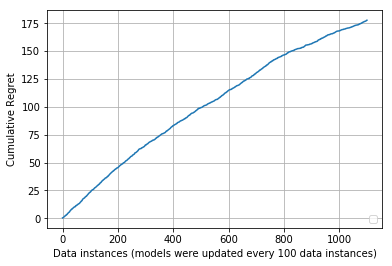

CPU times: user 541 ms, sys: 75.4 ms, total: 617 ms
Wall time: 682 ms


In [26]:
%%time
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
%matplotlib inline

plt.plot(all_regrets)

plt.legend(loc=4, prop={'size': 10})
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xlabel('Data instances (models were updated every %s data instances)' % batch_size, size=10)
plt.ylabel('Cumulative Regret', size=10)
plt.grid()
plt.show()

### Clean up

We have three DynamoDB tables (experiment, join, model) from the bandits application above (e.g. `experiment_id='bandits-exp-1'`). To better maintain them, we should remove the related records if the experiment has finished. Besides, having an endpoint running will incur costs. Therefore, we delete these components as part of the clean up process.

> Only execute the clean up cells below when you've finished the current experiment and want to deprecate everything associated with it. After the cleanup, the Cloudwatch metrics will not be populated anymore.

In [ ]:
bandits_experiment.clean_resource(experiment_id=bandits_experiment.experiment_id)

In [ ]:
bandits_experiment.clean_table_records(experiment_id=bandits_experiment.experiment_id)

## Local testing

VW C++ CLI should be installed on your instance

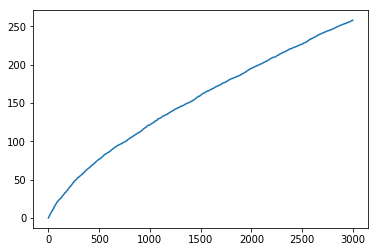

In [56]:
from src.vw_agent import VWAgent

agent = VWAgent(cli_args="--cb_explore_adf --cb_type mtr --epsilon 0")

# Start the VW C++ process
agent.start()

agent_cls = agent

env.reset()

all_rewards = []
all_regrets = []

done = False
num_iterations = 3000
all_scores_str = []

obs = env.reset()

for i in range(num_iterations):
    done = False

    user = obs[0].squeeze()
    items = np.array(obs[1:]).squeeze()
    scores = np.dot(items, user)

    max_score = scores.max()
    current_user_id = env.current_user_id


    actions, probs = agent_cls.choose_actions(user, items)
    action = actions[0]
    prob = probs[0]

    agent_cls.learn(user, items, action_index=action, reward=scores[action],
                    action_prob=prob, cost_fn= lambda reward: -reward)

    # Execute any action to step the environment
    obs, reward, done, info = env.step(actions)
    all_rewards.append(reward)
    all_regrets.append(info["total_regret"])

plt.plot(all_regrets)

In [57]:
agent.close()

b'creating quadratic features for pairs: sd \npredictions = /dev/stdout\nNum weight bits = 18\nlearning rate = 0.5\ninitial_t = 0\npower_t = 0.5\nusing no cache\nReading datafile = \nnum sources = 1\naverage  since         example        example  current  current  current\nloss     last          counter         weight    label  predict features\n    n.a.     n.a.            1            1.0  unknown        0:0.04...      467\n-8.704635 -8.704635            2            2.0    known        0:1...       21\n-4.511384 -0.318132            4            4.0    known        0:1...       19\n-2.377526 -0.243668            8            8.0    known        0:1...       19\n-1.354063 -0.330600           16           16.0    known        0:1...       21\n-0.834029 -0.313995           32           32.0    known        0:1...       15\n-0.594968 -0.355908           64           64.0    known        0:1...       18\n-0.485492 -0.376015          128          128.0    known        0:1...       18\n-0.